In [46]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from influxdb import InfluxDBClient
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(color_codes=True)
import pandas as pd
import numpy as np
import math

#from hisia import Hisia

In [2]:
client = InfluxDBClient(host='influxus.itu.dk', port=8086, username='lsda', password='icanonlyread')
client.switch_database('orkney')

In [3]:
def get_df(results):
    values = results.raw["series"][0]["values"]
    columns = results.raw["series"][0]["columns"]
    df = pd.DataFrame(values, columns=columns).set_index("time")
    df.index = pd.to_datetime(df.index) # Convert to datetime-index
    return df


# Get the last 14600 days (40 years) of power generation data
power = client.query(
    "SELECT mean(Total) FROM Generation WHERE time > now()-14600d GROUP BY time(3h)"
    ) # Query written in InfluxQL

# Get the last 14600 days (40 years) of weather forecasts with the shortest lead time
forecast = client.query( 
        "SELECT * FROM MetForecasts WHERE time > now()-14600d and time <= now()-1d"
        ) # Query written in InfluxQL

power_df = get_df(power)
forecast_df = get_df(forecast)

In [4]:
# Exploring the tables
display(power_df.head())
display(forecast_df.head())

,mean
time,
1981-10-20 12:00:00+00:00,NaN
1981-10-20 15:00:00+00:00,NaN
1981-10-20 18:00:00+00:00,NaN
1981-10-20 21:00:00+00:00,NaN
1981-10-21 00:00:00+00:00,NaN


,Direction,Lead_hours,Source_time,Speed
time,,,,
2019-03-28 12:00:00+00:00,SW,1,1553767200,16.98752
2019-03-28 15:00:00+00:00,SW,1,1553778000,16.09344
2019-03-28 15:00:00+00:00,SW,2,1553774400,16.09344
2019-03-28 15:00:00+00:00,SW,3,1553770800,15.19936
2019-03-28 15:00:00+00:00,SW,4,1553767200,15.19936


In [5]:
# Check shape and data types
print(power_df.shape)
print(power_df.dtypes)

(116801, 1)
mean    float64
dtype: object


In [6]:
print(forecast_df.shape)
print(forecast_df.dtypes)

(752243, 4)
Direction       object
Lead_hours      object
Source_time      int64
Speed          float64
dtype: object


In [7]:
#Direction and lead hours are cast into appropriate data types
forecast_df["Direction"] = forecast_df["Direction"].astype("category")
forecast_df["Lead_hours"] = forecast_df["Lead_hours"].astype("int64")

print(forecast_df.dtypes)

Direction      category
Lead_hours        int64
Source_time       int64
Speed           float64
dtype: object


In [8]:
# Check how many nan's
print(power_df.isnull().sum())
print(forecast_df.isnull().sum())

mean    92567
dtype: int64
Direction      0
Lead_hours     0
Source_time    0
Speed          0
dtype: int64


In [9]:
#Making a copy to not mess with OG data and backfilling missing values 
power_copy = power_df.copy()
power_copy.fillna(method="bfill", inplace = True)
power_copy

,mean
time,
1981-10-20 12:00:00+00:00,24.036500
1981-10-20 15:00:00+00:00,24.036500
1981-10-20 18:00:00+00:00,24.036500
1981-10-20 21:00:00+00:00,24.036500
1981-10-21 00:00:00+00:00,24.036500
...,...
2021-10-10 00:00:00+00:00,20.004583
2021-10-10 03:00:00+00:00,22.510567
2021-10-10 06:00:00+00:00,26.345422


In [11]:
# Merging the two dataframes
merged_df = forecast_df.join(power_copy)
merged_df

,Direction,Lead_hours,Source_time,Speed,mean
time,,,,,
2019-03-28 12:00:00+00:00,SW,1,1553767200,16.98752,28.059611
2019-03-28 15:00:00+00:00,SW,1,1553778000,16.09344,27.354461
2019-03-28 15:00:00+00:00,SW,2,1553774400,16.09344,27.354461
2019-03-28 15:00:00+00:00,SW,3,1553770800,15.19936,27.354461
2019-03-28 15:00:00+00:00,SW,4,1553767200,15.19936,27.354461
...,...,...,...,...,...
2021-10-09 12:00:00+00:00,SW,92,1633442400,5.81152,12.320544
2021-10-09 12:00:00+00:00,SW,93,1633438800,5.81152,12.320544
2021-10-09 12:00:00+00:00,SW,94,1633435200,5.81152,12.320544


In [12]:
merged_df.describe()

,Lead_hours,Source_time,Speed,mean
count,752243.000000,7.522430e+05,752243.000000,752243.000000
mean,54.320527,1.594298e+09,8.078132,16.868635
std,31.366015,2.289267e+07,3.468830,11.826992
min,1.000000,1.553767e+09,0.000000,-1.449078
25%,27.000000,1.574813e+09,4.917440,5.761356
50%,54.000000,1.594242e+09,8.046720,14.681039
75%,81.000000,1.614251e+09,9.834880,27.803278
max,119.000000,1.633770e+09,25.928320,41.992789


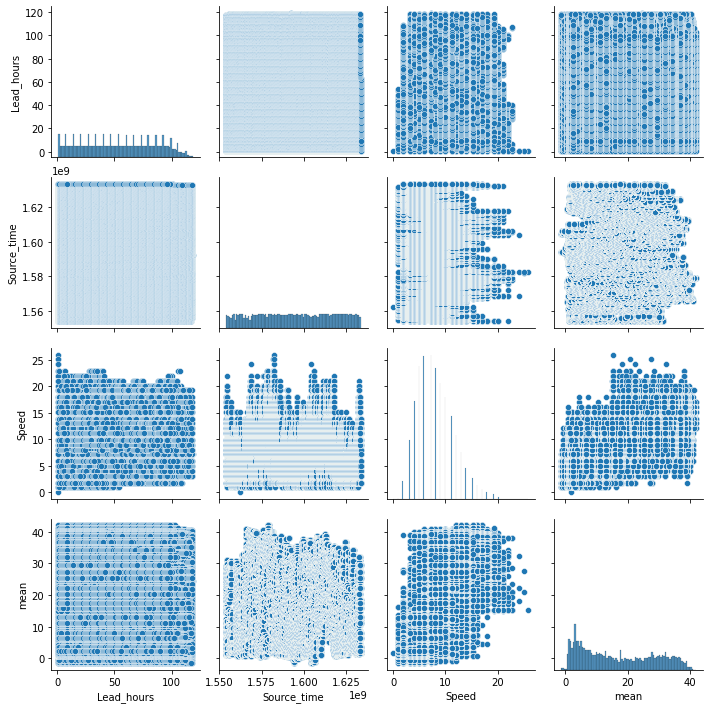

In [132]:
sns.pairplot(merged_df)

In [13]:
#Surprisingly only positive correlation found between speed and power generation /s
print(merged_df.corr())

             Lead_hours  Source_time     Speed      mean
Lead_hours     1.000000    -0.002007  0.015878 -0.000863
Source_time   -0.002007     1.000000 -0.106346 -0.108147
Speed          0.015878    -0.106346  1.000000  0.754434
mean          -0.000863    -0.108147  0.754434  1.000000


<AxesSubplot:xlabel='Speed', ylabel='mean'>

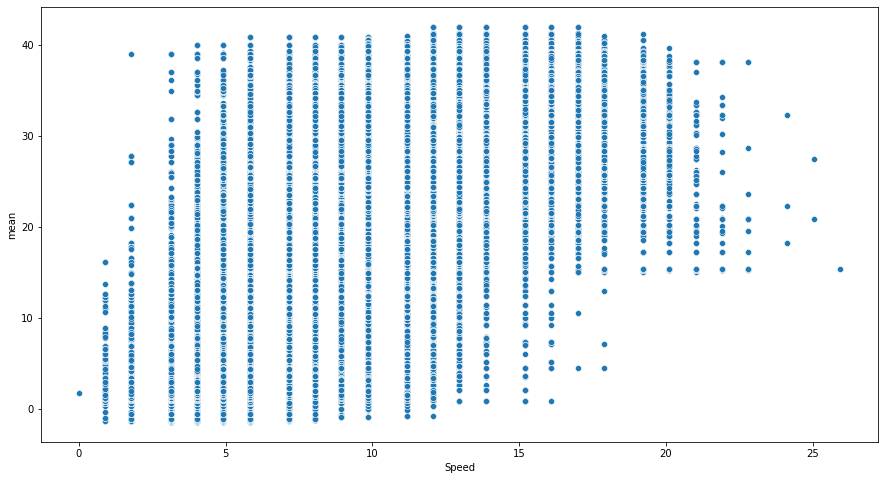

In [14]:
#Shows that the correlation is not linear
plt.figure(figsize=(15,8))
sns.scatterplot(data = merged_df, 
                x = "Speed", 
                y = "mean")

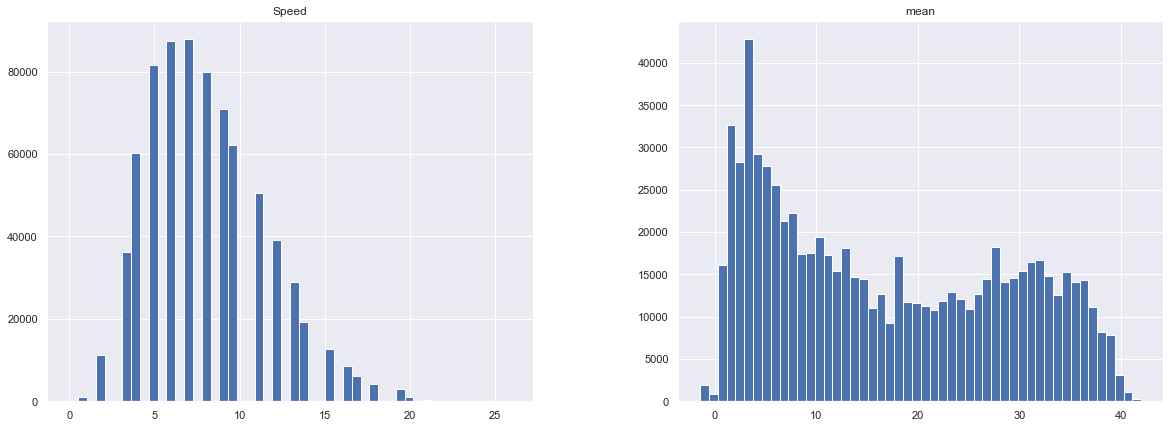

In [51]:
#Plotting histogram of wind speed and power generation side by side to visualize correlation
hist_df = merged_df.iloc[:,-2:]
hist_df.hist(bins=50, figsize=(20,7))
plt.show()

In [16]:
# All features except Wind power are defined as independent variables
X = merged_df.iloc[:,:-1]
# Wind power is defined as dependent variable
y = merged_df.iloc[:,-1:]

In [17]:
X.head()

,Direction,Lead_hours,Source_time,Speed
time,,,,
2019-03-28 12:00:00+00:00,SW,1,1553767200,16.98752
2019-03-28 15:00:00+00:00,SW,1,1553778000,16.09344
2019-03-28 15:00:00+00:00,SW,2,1553774400,16.09344
2019-03-28 15:00:00+00:00,SW,3,1553770800,15.19936
2019-03-28 15:00:00+00:00,SW,4,1553767200,15.19936


In [18]:
y.head()

,mean
time,
2019-03-28 12:00:00+00:00,28.059611
2019-03-28 15:00:00+00:00,27.354461
2019-03-28 15:00:00+00:00,27.354461
2019-03-28 15:00:00+00:00,27.354461
2019-03-28 15:00:00+00:00,27.354461


In [35]:
# Most of the below code is taken from the docs here:
# https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state = 42, 
                                                    shuffle = True,
                                                    test_size = 0.2)

# Numeric transformer uses MinMaxScaler to scale values between the set range of 0-1
# Categorical transformer uses OrdinalEncoder to encode Direction values from 1-16
# Creating lists of categorical and numerical features to be used in column transformer

numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())])
numeric_features = list(X_train.select_dtypes('number').columns)

categorical_transformer = OrdinalEncoder(handle_unknown='ignore')
categorical_features = list(X_train.select_dtypes('category').columns)

# Feeding transformers and features to preprocessor
train_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Creating pipeline with preprocessor and LinReg model
pipe = Pipeline(steps=[('preprocessor', train_preprocessor),
                      ('predictor', LinearRegression())])
# Fitting model
model = pipe.fit(X_train, y_train)

In [52]:
# Model prediction
y_hat = model.predict(X_test)

rmse = math.sqrt(mean_squared_error(y_test, y_hat))
r2 = r2_score(y_test, y_hat)

print("RMSE", rmse)
print("R2", r2)

RMSE 6.482168425284158
R2 0.489698047480264


In [53]:
#Prints the 10-fold cross validated scores of the above metrics
rmse_score = cross_val_score(model,
                             X, y,
                             scoring = 'neg_root_mean_squared_error',
                             cv = 10)
print("Average 10-Fold CV Score (RMSE):", np.mean(rmse_score))


r2_score = cross_val_score(model,
                             X, y,
                             scoring = 'r2',
                             cv = 10)
print("Average 10-Fold CV Score (R2):", np.mean(r2_score))

#Model appears to generalize well to unseen data

Average 10-Fold CV Score (RMSE): -7.817321764792548
Average 10-Fold CV Score (R2): 0.47475531109123625


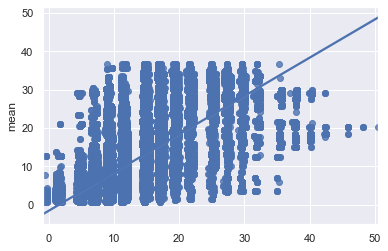

In [54]:
ax = sns.regplot(x=y_hat, y=y_test)

/home/saim/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/saim/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

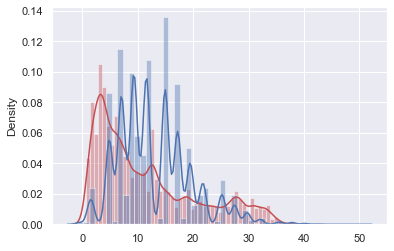

In [49]:
ax1 = sns.distplot(y_test, hist=True, color="r", label="Actual Value")
sns.distplot(y_hat, hist=True, color="b", label="Fitted Values" , ax=ax1)